In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import scipy.io
import os
from pyDOE import lhs
import shutil

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

import argparse

## 1、基础网络结构

网络结构分为普通的和带残差的全连接前馈神经网络(Fully-Connected Feedforward Network)。

### DNN

In [3]:
def activation(name):
    if name in ['tanh', 'Tanh']:
        return nn.Tanh()
    elif name in ['relu', 'ReLU']:
        return nn.ReLU(inplace=True)
    elif name in ['leaky_relu', 'LeakyReLU']:
        return nn.LeakyReLU(inplace=True)
    elif name in ['sigmoid', 'Sigmoid']:
        return nn.Sigmoid()
    elif name in ['softplus', 'Softplus']:
        return nn.Softplus()
    else: 
        raise ValueError(f'unknown activation function: {name}')

In [4]:
class DNN(nn.Module):
    """Deep Neural Network"""
    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers, 
                 act_name='tanh', init_name=None):
        super().__init__()
        model = nn.Sequential()
        
        model.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        model.add_module('act0', activation(act_name))
        for i in range(1, hidden_layers):
            model.add_module(f'fc{i}', nn.Linear(dim_hidden, dim_hidden, bias=True))
            model.add_module(f'act{i}', activation(act_name))
        model.add_module(f'fc{hidden_layers}', nn.Linear(dim_hidden, dim_out, bias=True))
        
        self.model = model
        if init_name is not None:
            self.init_weight(init_name)
            
    def init_weight(self, name):
        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init =  nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')
    
        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)
                
    def forward(self, x):
        return self.model(x)
    
    def forward_test(self, x):
        print(f"{'input':<20}{str(x.shape):<40}")
        for name, module in self.model._modules.items():
              x = module(x)
              print(f"{name:<20}{str(x.shape):<40}")
        return x              
    
    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params                

In [5]:
model = DNN(2, 1, 20, 4, init_name='kaiming_normal')
print(model)
print(model.model_size())

DNN(
  (model): Sequential(
    (fc0): Linear(in_features=2, out_features=20, bias=True)
    (act0): Tanh()
    (fc1): Linear(in_features=20, out_features=20, bias=True)
    (act1): Tanh()
    (fc2): Linear(in_features=20, out_features=20, bias=True)
    (act2): Tanh()
    (fc3): Linear(in_features=20, out_features=20, bias=True)
    (act3): Tanh()
    (fc4): Linear(in_features=20, out_features=1, bias=True)
  )
)
1341


### ResDNN

In [6]:
class ResBlock(nn.Module):
    def __init__(self, dim_in, dim_out, dim_hidden, act_name='tanh'):
        super().__init__()
        
        assert(dim_in == dim_out)
        block = nn.Sequential()
        block.add_module('act0', activation(act_name))
        block.add_module('fc0', nn.Linear(dim_in, dim_hidden, bias=True))
        block.add_module('act1', activation(act_name))
        block.add_module('fc1', nn.Linear(dim_hidden, dim_out, bias=True))
        self.block = block
        
    def forward(self, x):
        identity = x
        out = self.block(x)
        return identity + out

In [7]:
class ResDNN(nn.Module):
    def __init__(self, dim_in, dim_out, dim_hidden, res_blocks, act_name='tanh', init_name='kaiming_normal'):
        super().__init__()
        
        model = nn.Sequential()
        model.add_module('fc_first', nn.Linear(dim_in, dim_hidden, bias=True))
        for i in range(res_blocks):
            res_block = ResBlock(dim_hidden, dim_hidden, dim_hidden, act_name=act_name)
            model.add_module(f'res_block{i+1}', res_block)
        model.add_module('act_last', activation(act_name))
        model.add_module('fc_last', nn.Linear(dim_hidden, dim_out, bias=True))
        
        self.model = model
        if init_name is not None:
            self.init_weight(init_name)
        
    def init_weight(self, name):
        if name == 'xavier_normal':
            nn_init = nn.init.xavier_normal_
        elif name == 'xavier_uniform':
            nn_init = nn.init.xavier_uniform_
        elif name == 'kaiming_normal':
            nn_init = nn.init.kaiming_normal_
        elif name == 'kaiming_uniform':
            nn_init =  nn.init.kaiming_uniform_
        else:
            raise ValueError(f'unknown initialization function: {name}')
    
        for param in self.parameters():
            if len(param.shape) > 1:
                nn_init(param)

    def forward(self, x):
        return self.model(x)

    def forward_test(self, x):
        print(f"{'input':<20}{str(x.shape):<40}")
        for name, module in self.model._modules.items():
              x = module(x)
              print(f"{name:<20}{str(x.shape):<40}")
        return x              
    
    def model_size(self):
        n_params = 0
        for param in self.parameters():
            n_params += param.numel()
        return n_params

## 2、Burgers方程

考虑一维Burgers方程：
$$
\left\{
\begin{array}{rl}
u_t + uu_x - \frac{0.01}\pi u_{xx} = 0, & x \in[-1, 1], ~~ t \in [0, 1]\\
u(0, x) = - \sin(\pi x), & \\
u(t,-1) = u(t, 1) = 0.
\end{array}
\right.
$$

### 2.1、问题描述

In [8]:
class Problem_Burgers(object):
    """Description of Burgers equation."""
    def __init__(self, domain=(0, 1, -1, 1)):
        self.domain = domain
        
    def __repr__(self):
        return f'{self.__doc__}' 
    
    def f(self, x, verbose=None):
        num_data, _ = x.shape
        out = np.zeros((num_data, 1))
        if verbose == 'tensor':
            return torch.from_numpy(out).float()
        return out
    
    def g_bc(self, x_bc, verbose=None):
        num_data, _ = x_bc.shape
        out = np.zeros((num_data, 1))
        if verbose == 'tensor':
            return torch.from_numpy(out).float()
        return out
    
    def g_init(self, x_init, verbose=None):
        out = - np.sin(np.pi * x_init[:, [1]])
        if verbose == 'tensor':
            return torch.from_numpy(out).float()
        return out

### 2.2、数据集生成

In [9]:
class Trainset_Burgers(object):
    def __init__(self, problem, *args, **kwargs):
        self.problem = problem
        self.domain = problem.domain
        self.args = args
        self.method = kwargs['method']

    def __call__(self, plot=False, verbose=None):
        if self.method == 'uniform':
            n_x, n_y = self.args[0], self.args[1]
            x, x_bc, x_init = self._uniform_sample(n_x, n_y)
        elif self.method == 'lhs':
            n, n_bc = self.args[0], self.args[1]
            x, x_bc, x_init = self._lhs_sample(n, n_bc)
        f = self.problem.f(x)
        g_bc = self.problem.g_bc(x_bc)
        g_init = self.problem.g_init(x_init)

        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(x[:, 0], x[:, 1], facecolor='r', s=10)
            ax.scatter(x_bc[:, 0], x_bc[:, 1], facecolor='b', s=10)
            ax.scatter(x_init[:, 0], x_init[:, 1], facecolor='b', s=10)
            ax.set_xlim(-0.01, 1.01)
            ax.set_ylim(-1.01, 1.01)
            plt.show()

        if verbose == 'tensor':
            f = torch.from_numpy(f).float()
            g_bc = torch.from_numpy(g_bc).float()
            g_init = torch.from_numpy(g_init).float()
            x = torch.from_numpy(x).float()
            x_bc = torch.from_numpy(x_bc).float()
            x_init = torch.from_numpy(x_init).float()
            return x, x_bc, x_init, f, g_bc, g_init
        # (N, 2) & (N, 1)
        return x, x_bc, x_init, f, g_bc, g_init

    def _uniform_sample(self, n_x, n_y):
        t_min, t_max, x_min, x_max = self.domain
        t = np.linspace(t_min, t_max, n_x)
        x = np.linspace(x_min, x_max, n_y)
        t, x = np.meshgrid(t, x)  
        xy = np.hstack((t.reshape(t.size, -1), x.reshape(x.size, -1)))

        mask1 = (xy[:, 1] - x_min) * (x_max - xy[:, 1]) == 0
        mask2 = (xy[:, 0] - t_min) == 0
        mask3 = mask1 + mask2
        x_bc = xy[mask1]
        x_init = xy[mask2]
        x = xy[np.logical_not(mask3)]

        return x, x_bc, x_init

    def _lhs_sample(self, n, n_bc):
        t_min, t_max, x_min, x_max = self.domain

        lb = np.array([t_min, x_min])
        ub = np.array([t_max, x_max])
        x = lb + (ub - lb) * lhs(2, n)

        lb = np.array([t_min, x_min])
        ub = np.array([t_max, x_min])
        x_bc = lb + (ub - lb) * lhs(2, n_bc//3)

        lb = np.array([t_min, x_max])
        ub = np.array([t_max, x_max])
        temp = lb + (ub - lb) * lhs(2, n_bc//3)
        x_bc = np.vstack((x_bc, temp))

        lb = np.array([t_min, x_min])
        ub = np.array([t_min, x_max])
        x_init = lb + (ub - lb) * lhs(2, n_bc//3)
        return x, x_bc, x_init

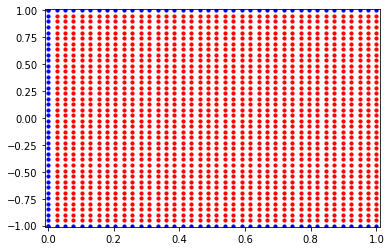

(1482, 2) (80, 2) (40, 2) (1482, 1) (80, 1) (40, 1)


In [12]:
problem = Problem_Burgers()
trainset = Trainset_Burgers(problem, 40, 40, method='uniform')
# trainset = Trainset_Burgers(problem, 1000, 400, method='lhs')

x, x_bc, x_init, f, g_bc, g_init = trainset(plot=True)
print(x.shape, x_bc.shape, x_init.shape, f.shape, g_bc.shape, g_init.shape)

In [14]:
class Testset_Burgers(object):
    """Dataset on a square domain"""
    def __init__(self, problem):
        self.problem = problem
        self.domain = problem.domain

    def __repr__(self):
        return f'{self.__doc__}'
        
    def __call__(self, plot=False, verbose=None):
        data = scipy.io.loadmat('burgers_shock.mat')
        x = data['x'].squeeze()
        t = data['t'].squeeze()
        t, x = np.meshgrid(t,x)
        X = np.hstack((t.reshape(t.size, -1), x.reshape(x.size, -1)))
        u = data['usol']
        
        if plot == True:
            fig = plt.figure()
            ax = fig.add_subplot(121)
            ax.scatter(X[:, 0], X[:, 1], facecolor='r', s=0.1)
            ax.set_xlim(-0.01, 1.01)
            ax.set_ylim(-1.01, 1.01)
            
            ax = fig.add_subplot(122, projection='3d')
            ax.plot_surface(t, x, u, cmap=cm.coolwarm)
            plt.show() 
            
        if verbose == 'tensor':
            X = torch.from_numpy(X).float()
            
        return X, t, x, u

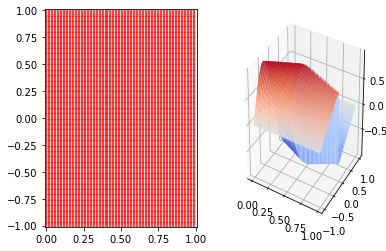

In [15]:
testset = Testset_Burgers(problem)
X, x, y, u = testset(plot=True)

### 2.3、网络结构

In [16]:
def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs
    
    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [17]:
class PINN(DNN):
    """Physics Constrained Neural Networks
    """
    def __init__(self, dim_in, dim_out, dim_hidden, hidden_layers, 
                 act_name='tanh', init_name='xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, hidden_layers, 
                         act_name=act_name, init_name=init_name)
        
    def forward(self, problem, x, x_bc=None, x_init=None):
        x.requires_grad_(True)
        u = super().forward(x)

        grad_u = grad(u, x)[0]     
        u_x = grad_u[:, [1]]
        u_t = grad_u[:, [0]]
        u_xx = grad(u_x, x)[0][:, [1]]
        x.detach_()
        f = u_t + u * u_x - (0.01 / np.pi) * u_xx
        if x_bc is not None:
            g_bc = super().forward(x_bc)
            g_init = super().forward(x_init)
            return u, f, g_bc, g_init
        return u, f

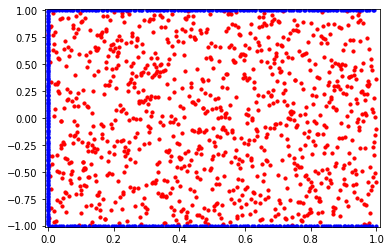

In [18]:
problem = Problem_Burgers()
trainset = Trainset_Burgers(problem, 1000, 400, method='lhs')
x, x_bc, x_init, f, g_bc, g_init = trainset(plot=True, verbose='tensor')

In [19]:
model = PINN(2, 1, 10, 8)
print(model.model_size())

u_pred, f_pred, g_bc, g_init = model(problem, x, x_bc, x_init)
print(u_pred.shape, f_pred.shape, g_bc.shape, g_init.shape)

811
torch.Size([1000, 1]) torch.Size([1000, 1]) torch.Size([266, 1]) torch.Size([133, 1])


### 2.4、Options

In [22]:
class Options_Burgers(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--dim_hidden', type=int, default=10, help='neurons in hidden layers')
        parser.add_argument('--hidden_layers', type=int, default=4, help='number of hidden layers')
        parser.add_argument('--res_blocks', type=int, default=4, help='number of residual blocks')
        parser.add_argument('--lam', type=float, default=1, help='weight in loss function')
        parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
        parser.add_argument('--epochs_Adam', type=int, default=5000, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=200, help='epochs for LBFGS optimizer')
        parser.add_argument('--step_size', type=int, default=2000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.7, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--resume', type=bool, default=False, help='resume or not')
        parser.add_argument('--sample_method', type=str, default='lhs', help='sample method')
        parser.add_argument('--n_x', type=int, default=100, help='sample points in x-direction for uniform sample')
        parser.add_argument('--n_y', type=int, default=100, help='sample points in y-direction for uniform sample')
        parser.add_argument('--n', type=int, default=10000, help='sample points in domain for lhs sample')
        parser.add_argument('--n_bc', type=int, default=400, help='sample points on the boundary for lhs sample')
        
        self.parser = parser
        
    def parse(self):
        arg = self.parser.parse_args(args=[])
        arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        arg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        return arg

### 2.5、训练过程

In [23]:
def save_model(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model.pth.tar')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth.tar')
        shutil.copyfile(last_model, best_model)

In [24]:
class Trainer_Burgers(object):
    def __init__(self, args):
        self.device  = args.device
        self.problem = args.problem
        
        self.lam = args.lam
        self.criterion = nn.MSELoss()
        
        self.model = args.model
        self.model_name = self.model.__class__.__name__
        self.model_path = self._model_path()
        
        self.epochs_Adam = args.epochs_Adam
        self.epochs_LBFGS = args.epochs_LBFGS
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=args.lr)
        self.optimizer_LBFGS = optim.LBFGS(self.model.parameters(), 
                                           max_iter=20, 
                                           tolerance_grad=1.e-8,
                                           tolerance_change=1.e-12)
        self.lr_scheduler = StepLR(self.optimizer_Adam, 
                                   step_size=args.step_size, 
                                   gamma=args.gamma)

        self.model.to(self.device)
        self.model.zero_grad()
        
        self.x,     self.x_bc,     self.x_init    , self.f    , self.g_bc    , self.g_init     = args.trainset(verbose='tensor')
        self.x_val, self.x_bc_val, self.x_init_val, self.f_val, self.g_bc_val, self.g_init_val = args.validset(verbose='tensor')
        
        if self.device == torch.device(type='cuda'):
            for item in [self.x, self.x_bc, self.x_init, self.f, self.g_bc, self.g_init, 
                         self.x_val, self.x_bc_val, self.x_init_val, self.f_val, self.g_bc_val, self.g_init_val]:
                item = item.to(self.device)
        
    def _model_path(self):
        """Path to save the model"""
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')

        path = os.path.join('checkpoints', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)
        return path
    
    def train(self):
        best_loss = 1.e10
        
        for epoch in range(self.epochs_Adam):
            loss, loss1, loss2 = self.train_Adam()
            if (epoch + 1) % 100 == 0:
                self.infos_Adam(epoch+1, loss, loss1, loss2)
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss                
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)
                
            
        for epoch in range(self.epochs_Adam, self.epochs_Adam + self.epochs_LBFGS):
            loss, loss1, loss2 = self.train_LBFGS()
            if (epoch + 1) % 20 == 0:
                self.infos_LBFGS(epoch+1, loss, loss1, loss2)
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss                
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)
            
    def train_Adam(self):
        self.optimizer_Adam.zero_grad()

        _, f_pred, g_bc, g_init = self.model(self.problem, self.x, self.x_bc, self.x_init)
        loss1 = self.criterion(f_pred, self.f)
        loss2 = self.criterion(g_bc, self.g_bc) + self.criterion(g_init, self.g_init)
        loss = loss1 + self.lam * loss2

        loss.backward()
        self.optimizer_Adam.step()
        self.lr_scheduler.step()

        return loss.item(), loss1.item(), loss2.item()

    def infos_Adam(self, epoch, loss, loss1, loss2):
        infos = 'Adam  ' + \
            f'Epoch #{epoch:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.4e} = {loss1:.4e} + {self.lam} * {loss2:.4e} ' + \
            f'lr: {self.lr_scheduler.get_lr()[0]:.2e} '
        print(infos)
        
    def train_LBFGS(self):

        # only used to compute loss_int and loss_bc1 for monitoring
        _, f_pred, g_bc, g_init = self.model(self.problem, self.x, self.x_bc, self.x_init)
        loss1 = self.criterion(f_pred, self.f)
        loss2 = self.criterion(g_bc, self.g_bc) + self.criterion(g_init, self.g_init)

        def closure():
            if torch.is_grad_enabled():
                self.optimizer_LBFGS.zero_grad()
            _, f_pred, g_bc, g_init = self.model(self.problem, self.x, self.x_bc, self.x_init)
            loss1 = self.criterion(f_pred, self.f)
            loss2 = self.criterion(g_bc, self.g_bc) + self.criterion(g_init, self.g_init)
            loss = loss1 + self.lam * loss2
            if loss.requires_grad:
                loss.backward()
            return loss

        self.optimizer_LBFGS.step(closure)
        loss = closure()

        return loss.item(), loss1.item(), loss2.item()
        
    def infos_LBFGS(self, epoch, loss, loss1, loss2):
        infos = 'LBFGS ' + \
            f'Epoch #{epoch:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.2e} = {loss1:.2e} + {self.lam:d} * {loss2:.2e} '
        print(infos)

    def validate(self, epoch):
        self.model.eval()
        _, f_pred, g_bc, g_init = self.model(self.problem, self.x_val, self.x_bc_val, self.x_init_val)
        loss1 = self.criterion(f_pred, self.f_val)
        loss2 = self.criterion(g_bc, self.g_bc_val) + self.criterion(g_init, self.g_init_val)
        loss = loss1 + self.lam * loss2
        
        infos = 'Valid ' + \
            f'Epoch #{epoch+1:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.4e} '
        print(infos)
        self.model.train()
        return loss.item()

In [25]:
# 使用Trainer_Burgers进行训练
args = Options_Burgers().parse()
args.problem = Problem_Burgers()
args.model = PINN(dim_in=2,
                  dim_out=1,
                  dim_hidden=args.dim_hidden,
                  hidden_layers=args.hidden_layers)

# args.model = ResPINN(2, 1, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)
if args.sample_method == 'uniform':
    args.trainset = Trainset_Burgers(args.problem, args.n_x, args.n_y, method='uniform')
elif args.sample_method == 'lhs':
    args.trainset = Trainset_Burgers(args.problem, args.n, args.n_bc, method='lhs')

args.validset = Trainset_Burgers(args.problem, 100, 100, method='uniform')
    
trainer = Trainer_Burgers(args)
trainer.train()

Adam  Epoch #  100/5200 Loss: 3.7859e-01 = 1.8818e-02 + 1 * 3.5977e-01 lr: 1.00e-03 
Valid Epoch #  100/5200 Loss: 3.7615e-01 
Adam  Epoch #  200/5200 Loss: 2.0413e-01 = 3.0363e-02 + 1 * 1.7376e-01 lr: 1.00e-03 
Valid Epoch #  200/5200 Loss: 2.0099e-01 
Adam  Epoch #  300/5200 Loss: 1.5532e-01 = 6.2339e-02 + 1 * 9.2985e-02 lr: 1.00e-03 
Valid Epoch #  300/5200 Loss: 1.5467e-01 
Adam  Epoch #  400/5200 Loss: 1.4812e-01 = 5.9486e-02 + 1 * 8.8635e-02 lr: 1.00e-03 
Valid Epoch #  400/5200 Loss: 1.4754e-01 
Adam  Epoch #  500/5200 Loss: 1.4161e-01 = 5.7407e-02 + 1 * 8.4207e-02 lr: 1.00e-03 
Valid Epoch #  500/5200 Loss: 1.4108e-01 
Adam  Epoch #  600/5200 Loss: 1.3737e-01 = 5.5661e-02 + 1 * 8.1705e-02 lr: 1.00e-03 
Valid Epoch #  600/5200 Loss: 1.3680e-01 
Adam  Epoch #  700/5200 Loss: 1.3224e-01 = 5.2919e-02 + 1 * 7.9325e-02 lr: 1.00e-03 
Valid Epoch #  700/5200 Loss: 1.3162e-01 
Adam  Epoch #  800/5200 Loss: 1.2551e-01 = 5.0086e-02 + 1 * 7.5420e-02 lr: 1.00e-03 
Valid Epoch #  800/5200 Lo

### 2.6、测试过程

In [98]:
class Tester_Burgers(object):
    def __init__(self, args):
        self.device  = args.device
        self.problem = args.problem
        self.criterion = nn.MSELoss()
        self.model = args.model
        model_name = self.model.__class__.__name__
        model_path = os.path.join('checkpoints',
                                  model_name,
                                  'best_model.pth.tar')
        best_model = torch.load(model_path)
        self.model.load_state_dict(best_model['state_dict'])        
        self.model.to(self.device)
        self.X, self.t, self.x, self.u = args.testset(verbose='tensor')
        if self.device == torch.device(type='cuda'):
            self.X = self.X.to(self.device)
    
    def predict(self):
        self.model.eval()
        u_pred, _ = self.model(self.problem, self.X)
        u_pred = u_pred.detach().cpu().numpy()
        u_pred = u_pred.reshape(self.x.shape)
        
        fig = plt.figure()
        ax = fig.add_subplot(131, projection='3d')
        ax.plot_surface(self.t, self.x, self.u, cmap=cm.coolwarm)
        ax = fig.add_subplot(132, projection='3d')
        ax.plot_surface(self.t, self.x, u_pred, cmap=cm.coolwarm)
        ax = fig.add_subplot(133, projection='3d')
        ax.plot_surface(self.t, self.x, np.abs(u_pred-self.u), cmap=cm.coolwarm)
        ax.set_xlim(-0.01, 1.01)
        ax.set_ylim(-1.01, 1.01)

    def plot(self):
        self.model.eval()
        u_pred, _ = self.model(self.problem, self.X)
        u_pred = u_pred.detach().cpu().numpy()
        u_pred = u_pred.reshape(self.x.shape)
        fig, ax = plt.subplots(figsize=(10, 9))
        ax.axis('off')  
        
        ####### Row 0: u(t,x) ################## 
        gs0 = gridspec.GridSpec(1, 2)
        gs0.update(top=1-0.06, bottom=1-1.0/3.0+0.06, left=0.15, right=0.85, wspace=0)
        ax = plt.subplot(gs0[:, :])

        h = ax.imshow(u_pred, interpolation='nearest', cmap='rainbow', 
                      extent=[self.t.min(), self.t.max(), self.x.min(), self.x.max()], 
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(h, cax=cax)

        line = np.linspace(self.x.min(), self.x.max(), 2)[:, None]
        ax.plot(self.t[:, 25]*np.ones((2,1)), line, 'w-', linewidth = 1)
        ax.plot(self.t[:, 50]*np.ones((2,1)), line, 'w-', linewidth = 1)
        ax.plot(self.t[:, 75]*np.ones((2,1)), line, 'w-', linewidth = 1)

        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_title('$u(t,x)$', fontsize = 10)
        
        ####### Row 1: u(t,x) slices ##################    
        gs1 = gridspec.GridSpec(1, 3)
        gs1.update(top=1-1.0/3.0-0.1, bottom=1.0-2.0/3.0, left=0.1, right=0.9, wspace=0.5)

        ax = plt.subplot(gs1[0, 0])
        ax.plot(self.x[:, 0],self.u[:, 25], 'b-', linewidth = 2, label = 'Exact')       
        ax.plot(self.x[:, 0],u_pred[:, 25], 'r--', linewidth = 2, label = 'Prediction')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$u(t,x)$')    
        ax.set_title('$t = 0.25$', fontsize = 10)
        ax.axis('square')
        ax.set_xlim([-1.1,1.1])
        ax.set_ylim([-1.1,1.1])

        ax = plt.subplot(gs1[0, 1])
        ax.plot(self.x[:, 0],self.u[:, 50], 'b-', linewidth = 2, label = 'Exact')       
        ax.plot(self.x[:, 0],u_pred[:, 50], 'r--', linewidth = 2, label = 'Prediction')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$u(t,x)$')
        ax.axis('square')
        ax.set_xlim([-1.1,1.1])
        ax.set_ylim([-1.1,1.1])
        ax.set_title('$t = 0.50$', fontsize = 10)
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

        ax = plt.subplot(gs1[0, 2])
        ax.plot(self.x[:, 0],u_pred[:, 75], 'b-', linewidth = 2, label = 'Exact')       
        ax.plot(self.x[:, 0],u_pred[:, 75], 'r--', linewidth = 2, label = 'Prediction')
        ax.set_xlabel('$x$')
        ax.set_ylabel('$u(t,x)$')
        ax.axis('square')
        ax.set_xlim([-1.1,1.1])
        ax.set_ylim([-1.1,1.1])    
        ax.set_title('$t = 0.75$', fontsize = 10)


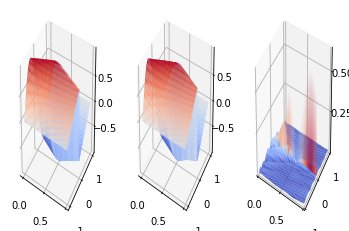

In [99]:
# 使用Tester_Burgers进行预测，复现文章中的Figure1（只画出预测结果）
args = Options_Burgers().parse()
args.problem = Problem_Burgers()

args.model = PINN(2, 1, dim_hidden=args.dim_hidden, hidden_layers=args.hidden_layers)
args.testset = Testset_Burgers(args.problem)  
tester = Tester_Burgers(args)
tester.predict()

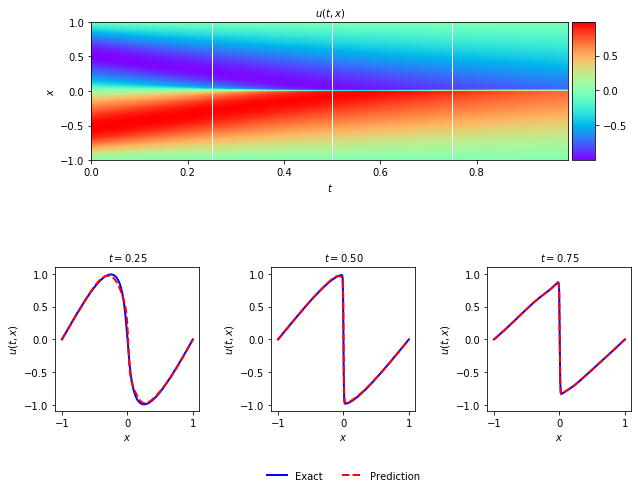

In [100]:
tester.plot()

## 3、非线性薛定谔方程

考虑带周期边界条件的非线性薛定谔方程：
$$
\left\{
\begin{array}{rl}
i h_t + 0.5 h_{xx} + |h|^2 h = 0, & x \in[-5, 5], ~~ t \in [0, \pi/2]\\
h(0, x) = 2\mathrm{sech}(x), & \\
h(t,-5) = h(t, 5), & \\
h_x(t, -5) = h_x(t, 5), & 
\end{array}
\right.
$$
其中$h(t,x)$为复值函数。

### 3.1、问题描述

In [11]:
class Problem_Schrodinger(object):
    """Description of Schrodinger equation."""
    def __init__(self, domain=(0, np.pi/2, -5, 5)):
        self.domain = domain
        
    def __repr__(self):
        return f'{self.__doc__}' 
    
    def f(self, x, verbose=None):
        num_data, _ = x.shape
        out_u = np.zeros((num_data, 1))
        out_v = np.zeros((num_data, 1))
        if verbose == 'tensor':
            return torch.from_numpy(out_u).float(), torch.from_numpy(out_v).float()
        return out_u, out_v
    
    def g_init(self, x_init, verbose=None):
        num_data, _ = x_init.shape
        out_u = 2.0 / np.cosh(x_init[:, [1]])
        out_v = np.zeros((num_data, 1))
        if verbose == 'tensor':
            return torch.from_numpy(out_u).float(), torch.from_numpy(out_v).float()
        return out_u, out_v
    
    def g_bc_1(self, x_bc_1, verbose=None):
        num_data, _ = x_bc_1.shape
        out_u = np.zeros((num_data, 1))
        out_v = np.zeros((num_data, 1))
        if verbose == 'tensor':
            return torch.from_numpy(out_u).float(), torch.from_numpy(out_v).float()
        return out_u, out_v
    
    def g_bc_2(self, x_bc_2, verbose=None):
        num_data, _ = x_bc_2.shape
        out_u = np.zeros((num_data, 1))
        out_v = np.zeros((num_data, 1))
        if verbose == 'tensor':
            return torch.from_numpy(out_u).float(), torch.from_numpy(out_v).float()
        return out_u, out_v

### 3.2、数据集生成

In [12]:
class Trainset_Schrodinger(object):
    def __init__(self, problem, *args, **kwargs):
        self.problem = problem
        self.domain = problem.domain
        self.args = args
        self.method = kwargs['method']

    def __call__(self, plot=False, verbose=None):
        if self.method == 'uniform':
            n_x, n_y = self.args[0], self.args[1]
            x, x_bc_1, x_bc_2, x_init = self._uniform_sample(n_x, n_y)
        elif self.method == 'lhs':
            n, n_bc = self.args[0], self.args[1]
            x, x_bc_1, x_bc_2, x_init = self._lhs_sample(n, n_bc)
        f = self.problem.f(x)
        g_init = self.problem.g_init(x_init)
        g_bc_1 = self.problem.g_bc_1(x_bc_1)
        g_bc_2 = self.problem.g_bc_2(x_bc_2)

        if plot:
            fig = plt.figure()
            ax = fig.add_subplot(111)
            ax.scatter(x[:, 0], x[:, 1], facecolor='r', s=10)
            ax.scatter(x_bc_1[:, 0], x_bc_1[:, 1], facecolor='b', s=10)
            ax.scatter(x_bc_2[:, 0], x_bc_2[:, 1], facecolor='b', s=10)
            ax.scatter(x_init[:, 0], x_init[:, 1], facecolor='b', s=10)
            ax.set_xlim(-0.01, 0.01+np.pi/2)
            ax.set_ylim(-5.2, 5.2)
            plt.show()

        if verbose == 'tensor':
            f = torch.from_numpy(f).float()
            g_init = torch.from_numpy(g_init).float()
            g_bc_1 = torch.from_numpy(g_bc_1).float()
            g_bc_2 = torch.from_numpy(g_bc_2).float()
            x = torch.from_numpy(x).float()
            x_bc_1 = torch.from_numpy(x_bc_1).float()
            x_bc_2 = torch.from_numpy(x_bc_2).float()
            x_init = torch.from_numpy(x_init).float()
            return x, x_bc_1, x_bc_2, x_init, f, g_init, g_bc_1, g_bc_2
        # (N, 2)
        return x, x_bc_1, x_bc_2, x_init, f, g_init, g_bc_1, g_bc_2

    def _uniform_sample(self, n_x, n_y):
        t_min, t_max, x_min, x_max = self.domain
        t = np.linspace(t_min, t_max, n_x)
        x = np.linspace(x_min, x_max, n_y)
        t, x = np.meshgrid(t, x)  
        xy = np.hstack((t.reshape(t.size, -1), x.reshape(x.size, -1)))

        mask0 = (x_max - xy[:, 1]) == 0
        mask1 = (xy[:, 1] - x_min) == 0
        mask2 = (xy[:, 0] - t_min) == 0
        mask3 = mask0 + mask1 + mask2
        x_bc_1 = xy[mask0]
        x_bc_2 = xy[mask1]
        x_init = xy[mask2]
        x = xy[np.logical_not(mask3)]

        return x, x_bc_1, x_bc_2, x_init

    def _lhs_sample(self, n, n_bc):
        t_min, t_max, x_min, x_max = self.domain

        lb = np.array([t_min, x_min])
        ub = np.array([t_max, x_max])
        x = lb + (ub - lb) * lhs(2, n)
        
        sample = lhs(2, n_bc//2)
        lb = np.array([t_min, x_min])
        ub = np.array([t_max, x_min])
        x_bc_1 = lb + (ub - lb) * sample

        lb = np.array([t_min, x_max])
        ub = np.array([t_max, x_max])
        x_bc_2 = lb + (ub - lb) * sample

        lb = np.array([t_min, x_min])
        ub = np.array([t_min, x_max])
        x_init = lb + (ub - lb) * lhs(2, n_bc//2)
        return x, x_bc_1, x_bc_2, x_init

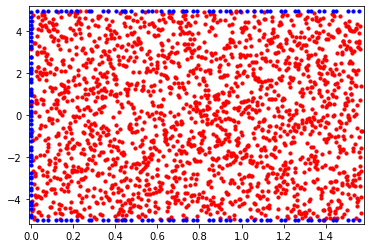

(2000, 2) (50, 2) (50, 2) (50, 2)


In [13]:
problem = Problem_Schrodinger()
# trainset = Trainset_Schrodinger(problem, 40, 40, method='uniform')
trainset = Trainset_Schrodinger(problem, 2000, 100, method='lhs')

x, x_bc_1, x_bc_2, x_init, f, g_init, g_bc_1, g_bc_2 = trainset(plot=True)
print(x.shape, x_bc_1.shape, x_bc_2.shape, x_init.shape)

In [14]:
class Testset_Schrodinger(object):
    def __init__(self, problem, *args, **kwargs):
        self.problem = problem
        self.domain = problem.domain
        self.args = args
        self.method = kwargs['method']

    def __repr__(self):
        return f'{self.__doc__}'
        
    def __call__(self, plot=False, verbose=None):
        if self.method == 'uniform':
            n_x, n_y = self.args[0], self.args[1]
            X, t, x = self._uniform_sample(n_x, n_y)
        elif self.method == 'ground_truth':
            data = scipy.io.loadmat('NLS.mat')
            t = data['tt'].flatten()[:,None]
            x = data['x'].flatten()[:,None]
            Exact = data['uu']
            Exact_u = np.real(Exact)
            Exact_v = np.imag(Exact)
            Exact_h = np.sqrt(Exact_u**2 + Exact_v**2)
            t, x = np.meshgrid(t, x)
            X = np.hstack((t.reshape(t.size, -1), x.reshape(x.size, -1)))
            if plot == True:
                fig = plt.figure()
                ax = fig.add_subplot(121)
                ax.scatter(X[:, 0], X[:, 1], facecolor='r', s=0.01)
                ax.set_xlim(-0.01, np.pi/2+0.01)
                ax.set_ylim(-5.1, 5.1)
                ax = fig.add_subplot(122, projection='3d')
                ax.plot_surface(t, x, Exact_h, cmap=cm.coolwarm)
                plt.show() 
            
        if verbose == 'tensor':
            X = torch.from_numpy(X).float()
            
        if self.method == 'uniform':
            return X, t, x
        elif self.method == 'ground_truth':
            return X, t, x, Exact_h

    def _uniform_sample(self, n_x, n_y):
        t_min, t_max, x_min, x_max = self.domain
        t = np.linspace(t_min, t_max, n_x)
        x = np.linspace(x_min, x_max, n_y)
        t, x = np.meshgrid(t, x)
        X = np.hstack((t.reshape(t.size, -1), x.reshape(x.size, -1)))
        return X, t, x

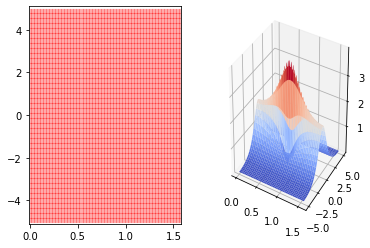

In [15]:
testset = Testset_Schrodinger(problem, 40, 40, method='ground_truth')
X, t, x, h = testset(plot=True)

### 3.3、网络结构

In [16]:
def grad(outputs, inputs):
    """ compute the derivative of outputs associated with inputs
    
    Params
    ======
    outputs: (N, 1) tensor
    inputs: (N, D) tensor
    """
    return torch.autograd.grad(outputs, inputs,
                               grad_outputs=torch.ones_like(outputs),
                               create_graph=True)

In [17]:
class ResPINN_Schrodinger(ResDNN):
    """Physics Constrained Neural Networks
    """
    def __init__(self, dim_in, dim_out, dim_hidden, res_blocks,
                 act_name='tanh', init_name='xavier_normal'):
        super().__init__(dim_in, dim_out, dim_hidden, res_blocks, 
                         act_name=act_name, init_name=init_name)
        
    def forward(self, problem, x, x_bc_1=None, x_bc_2=None, x_init=None):
        x.requires_grad_(True)
        uv = super().forward(x)

        u = uv[:, [0]]
        v = uv[:, [1]]
        grad_u = grad(u, x)[0]
        grad_v = grad(v, x)[0]   
        u_t = grad_u[:, [0]]
        v_t = grad_v[:, [0]]
        u_x = grad_u[:, [1]]
        v_x = grad_v[:, [1]]
        u_xx = grad(u_x, x)[0][:, [1]]
        v_xx = grad(v_x, x)[0][:, [1]]            
        x.detach_()
       
        f_1 = v_t - 0.5 * u_xx - u * (u ** 2 + v ** 2)
        f_2 = u_t + 0.5 * v_xx + v * (u ** 2 + v ** 2)
        
        if x_init is not None:
            g_init = super().forward(x_init)
            x_bc_1.requires_grad_(True)
            x_bc_2.requires_grad_(True)  
            h_1 = super().forward(x_bc_1)
            h_2 = super().forward(x_bc_2)
  
            ux_1 = grad(h_1[:, [0]], x_bc_1)[0][:, [1]]
            ux_2 = grad(h_2[:, [0]], x_bc_2)[0][:, [1]]
            vx_1 = grad(h_1[:, [1]], x_bc_1)[0][:, [1]]
            vx_2 = grad(h_2[:, [1]], x_bc_2)[0][:, [1]]
            x_bc_1.detach_()
            x_bc_2.detach_()
            
            g_init_u = g_init[:, [0]]
            g_init_v = g_init[:, [1]]
            g_bc_1_u = h_1[:, [0]] - h_2[:, [0]]
            g_bc_1_v = h_1[:, [1]] - h_2[:, [1]]
            g_bc_2_u = ux_1 - ux_2
            g_bc_2_v = vx_1 - vx_2
            
            return uv, f_1, f_2, g_init_u, g_init_v, g_bc_1_u, g_bc_1_v, g_bc_2_u, g_bc_2_v
        return uv, f_1, f_2

### 3.4、Options

In [18]:
class Options_Schrodinger(object):
    def __init__(self):
        parser = argparse.ArgumentParser()
        parser.add_argument('--no_cuda', action='store_true', default=False, help='disable CUDA or not')
        parser.add_argument('--dim_hidden', type=int, default=20, help='neurons in hidden layers')
        parser.add_argument('--hidden_layers', type=int, default=5, help='number of hidden layers')
        parser.add_argument('--res_blocks', type=int, default=6, help='number of residual blocks')
        parser.add_argument('--lam', type=float, default=1, help='weight in loss function')
        parser.add_argument('--lr', type=float, default=1e-3, help='initial learning rate')
        parser.add_argument('--epochs_Adam', type=int, default=2000, help='epochs for Adam optimizer')
        parser.add_argument('--epochs_LBFGS', type=int, default=100, help='epochs for LBFGS optimizer')
        parser.add_argument('--step_size', type=int, default=1000, help='step size in lr_scheduler for Adam optimizer')
        parser.add_argument('--gamma', type=float, default=0.7, help='gamma in lr_scheduler for Adam optimizer')
        parser.add_argument('--resume', type=bool, default=False, help='resume or not')
        parser.add_argument('--sample_method', type=str, default='uniform', help='sample method')
        parser.add_argument('--n_x', type=int, default=100, help='sample points in x-direction for uniform sample')
        parser.add_argument('--n_y', type=int, default=100, help='sample points in y-direction for uniform sample')
        parser.add_argument('--n', type=int, default=5000, help='sample points in domain for lhs sample')
        parser.add_argument('--n_bc', type=int, default=100, help='sample points on the boundary for lhs sample')
        
        self.parser = parser
    def parse(self):
        arg = self.parser.parse_args(args=[])
        arg.cuda = not arg.no_cuda and torch.cuda.is_available()
        arg.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        return arg


### 3.5、训练过程

In [19]:
def save_model(state, is_best=None, save_dir=None):
    last_model = os.path.join(save_dir, 'last_model.pth.tar')
    torch.save(state, last_model)
    if is_best:
        best_model = os.path.join(save_dir, 'best_model.pth.tar')
        shutil.copyfile(last_model, best_model)

In [12]:
class Trainer_Schrodinger(object):
    def __init__(self, args):
        self.device  = args.device
        self.problem = args.problem
        
        self.lam = args.lam
        self.criterion = nn.MSELoss()
        
        self.model = args.model
        self.model_name = self.model.__class__.__name__
        self.model_path = self._model_path()
        
        self.epochs_Adam = args.epochs_Adam
        self.epochs_LBFGS = args.epochs_LBFGS
        self.optimizer_Adam = optim.Adam(self.model.parameters(), lr=args.lr)
        self.optimizer_LBFGS = optim.LBFGS(self.model.parameters(), 
                                           max_iter=20, 
                                           tolerance_grad=1.e-8,
                                           tolerance_change=1.e-12)
        self.lr_scheduler = StepLR(self.optimizer_Adam, 
                                   step_size=args.step_size, 
                                   gamma=args.gamma)

        self.model.to(self.device)
        self.model.zero_grad()
        self.x,     self.x_bc_1,     self.x_bc_2,     self.x_init    , self.f    , self.g_init    , self.g_bc_1    , self.g_bc_2     = args.trainset(verbose='tensor')
        self.x_val, self.x_bc_1_val, self.x_bc_2_val, self.x_init_val, self.f_val, self.g_init_val, self.g_bc_1_val, self.g_bc_2_val = args.validset(verbose='tensor')
        
        if self.device == torch.device(type='cuda'):
            for item in [self.x, self.x_bc_1, self.x_bc_2, self.x_init, self.f, self.g_bc_1, self.g_bc_2, self.g_init, 
                         self.x_val, self.x_bc_1_val, self.x_bc_2_val, self.x_init_val, self.f_val, self.g_bc_1_val, self.g_bc_2_val, self.g_init_val]:
                item = item.to(self.device)
        
    def _model_path(self):
        """Path to save the model"""
        if not os.path.exists('checkpoints'):
            os.mkdir('checkpoints')

        path = os.path.join('checkpoints', self.model_name)
        if not os.path.exists(path):
            os.mkdir(path)
        return path
    
    def train(self):
        best_loss = 1.e10
        
        for epoch in range(self.epochs_Adam):
            loss, loss1, loss2 = self.train_Adam()
            if (epoch + 1) % 100 == 0:
                self.infos_Adam(epoch+1, loss, loss1, loss2)
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss                
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)
                
            
        for epoch in range(self.epochs_Adam, self.epochs_Adam + self.epochs_LBFGS):
            loss, loss1, loss2 = self.train_LBFGS()
            if (epoch + 1) % 20 == 0:
                self.infos_LBFGS(epoch+1, loss, loss1, loss2)
                
                valid_loss = self.validate(epoch)
                is_best = valid_loss < best_loss
                best_loss = valid_loss if is_best else best_loss                
                state = {
                    'epoch': epoch,
                    'state_dict': self.model.state_dict(),
                    'best_loss': best_loss
                }
                save_model(state, is_best, save_dir=self.model_path)
            
    def train_Adam(self):
        self.optimizer_Adam.zero_grad()

        _, f_pred, g_bc_1, g_bc_2, g_init = self.model(self.problem, self.x, self.x_bc_1, self.x_bc_2, self.x_init)
        loss1 = self.criterion(f_pred, self.f)
        loss2 = self.criterion(g_bc_1, self.g_bc_1) + self.criterion(g_bc_2, self.g_bc_2) + self.criterion(g_init, self.g_init)
        loss = loss1 + self.lam * loss2

        loss.backward()
        self.optimizer_Adam.step()
        self.lr_scheduler.step()

        return loss.item(), loss1.item(), loss2.item()

    def infos_Adam(self, epoch, loss, loss1, loss2):
        infos = 'Adam  ' + \
            f'Epoch #{epoch:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.4e} = {loss1:.4e} + {self.lam} * {loss2:.4e} ' + \
            f'lr: {self.lr_scheduler.get_lr()[0]:.2e} '
        print(infos)
        
    def train_LBFGS(self):

        # only used to compute loss_int and loss_bc1 for monitoring
        _, f_pred, g_init, g_bc_1, g_bc_2 = self.model(self.problem, self.x, self.x_bc_1, self.x_bc_2, self.x_init)
        loss1 = self.criterion(f_pred, self.f)
        loss2 = self.criterion(g_bc_1, self.g_bc_1) + self.criterion(g_bc_2, self.g_bc_2) + self.criterion(g_init, self.g_init)

        def closure():
            if torch.is_grad_enabled():
                self.optimizer_LBFGS.zero_grad()
            _, f_pred, g_bc_1, g_bc_2, g_init = self.model(self.problem, self.x, self.x_bc_1, self.x_bc_2, self.x_init)
            loss1 = self.criterion(f_pred, self.f)
            loss2 = self.criterion(g_bc_1, self.g_bc_1) + self.criterion(g_bc_2, self.g_bc_2) + self.criterion(g_init, self.g_init)
            loss = loss1 + self.lam * loss2
            if loss.requires_grad:
                loss.backward()
            return loss

        self.optimizer_LBFGS.step(closure)
        loss = closure()

        return loss.item(), loss1.item(), loss2.item()
        
    def infos_LBFGS(self, epoch, loss, loss1, loss2):
        infos = 'LBFGS ' + \
            f'Epoch #{epoch:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.2e} = {loss1:.2e} + {self.lam:d} * {loss2:.2e} '
        print(infos)

    def validate(self, epoch):
        self.model.eval()
        _, f_pred, g_bc_1, g_bc_2, g_init = self.model(self.problem, self.x_val, self.x_bc_1_val, self.x_bc_2_val, self.x_init_val)
        loss1 = self.criterion(f_pred, self.f_val)
        loss2 = self.criterion(g_bc_1, self.g_bc_1_val) + self.criterion(g_bc_2, self.g_bc_2_val) + self.criterion(g_init, self.g_init_val)
        loss = loss1 + self.lam * loss2
        
        infos = 'Valid ' + \
            f'Epoch #{epoch+1:5d}/{self.epochs_Adam+self.epochs_LBFGS} ' + \
            f'Loss: {loss:.4e} '
        print(infos)
        self.model.train()
        return loss.item()

In [31]:
# 使用Trainer_Schrodinger进行训练
args = Options_Schrodinger().parse()
args.problem = Problem_Schrodinger()
args.model = ResPINN_Schrodinger(2, 2, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)
if args.sample_method == 'uniform':
    args.trainset = Trainset_Schrodinger(args.problem, args.n_x, args.n_y, method='uniform')
elif args.sample_method == 'lhs':
    args.trainset = Trainset_Schrodinger(args.problem, args.n, args.n_bc, method='lhs')

args.validset = Trainset_Schrodinger(args.problem, 100, 100, method='uniform')
    
trainer = Trainer_Schrodinger(args)
trainer.train()

Adam  Epoch #  100/2200 Loss: 2.6155e-01 = 4.1477e-02 + 1 * 2.2008e-01 lr: 1.00e-03 
Valid Epoch #  100/2200 Loss: 2.6036e-01 
Adam  Epoch #  200/2200 Loss: 1.7444e-01 = 3.4716e-02 + 1 * 1.3972e-01 lr: 1.00e-03 
Valid Epoch #  200/2200 Loss: 1.7344e-01 
Adam  Epoch #  300/2200 Loss: 8.3542e-02 = 3.5125e-02 + 1 * 4.8418e-02 lr: 1.00e-03 
Valid Epoch #  300/2200 Loss: 8.2965e-02 
Adam  Epoch #  400/2200 Loss: 4.5417e-02 = 2.5249e-02 + 1 * 2.0168e-02 lr: 1.00e-03 
Valid Epoch #  400/2200 Loss: 4.5178e-02 
Adam  Epoch #  500/2200 Loss: 2.9596e-02 = 1.8712e-02 + 1 * 1.0885e-02 lr: 1.00e-03 
Valid Epoch #  500/2200 Loss: 2.9498e-02 
Adam  Epoch #  600/2200 Loss: 2.2830e-02 = 1.4980e-02 + 1 * 7.8502e-03 lr: 1.00e-03 
Valid Epoch #  600/2200 Loss: 2.2784e-02 
Adam  Epoch #  700/2200 Loss: 1.9310e-02 = 1.2908e-02 + 1 * 6.4024e-03 lr: 1.00e-03 
Valid Epoch #  700/2200 Loss: 1.9283e-02 
Adam  Epoch #  800/2200 Loss: 1.6949e-02 = 1.1487e-02 + 1 * 5.4624e-03 lr: 1.00e-03 
Valid Epoch #  800/2200 Lo

### 3.6、测试过程

In [25]:
class Tester_Schrodinger(object):
    def __init__(self, args):
        self.device  = args.device
        self.problem = args.problem
        self.criterion = nn.MSELoss()
        self.model = args.model
        model_name = self.model.__class__.__name__
        model_path = os.path.join('checkpoints',
                                  model_name,
                                  'best_model.pth.tar')
        best_model = torch.load(model_path)
        self.model.load_state_dict(best_model['state_dict'])        
        self.model.to(self.device)
        self.X, self.t, self.x, self.h_tar = args.testset(verbose='tensor')
        if self.device == torch.device(type='cuda'):
            self.X = self.X.to(self.device)
    
    def predict(self):
        self.model.eval()
        uv_pred, _ = self.model(self.problem, self.X)
        uv_pred = uv_pred.detach().cpu().numpy()
        uv_pred = np.sqrt(uv_pred[:, [0]] ** 2 + uv_pred[:, [1]] ** 2)
        uv_pred = uv_pred.reshape(self.x.shape)
        
        fig = plt.figure()
        ax = fig.add_subplot(131, projection='3d')
        ax.plot_surface(self.t, self.x, self.h_tar, cmap=cm.coolwarm)
        ax = fig.add_subplot(132, projection='3d')
        ax.plot_surface(self.t, self.x, uv_pred, cmap=cm.coolwarm)
        ax = fig.add_subplot(133, projection='3d')
        ax.plot_surface(self.t, self.x, np.abs(uv_pred-self.h_tar), cmap=cm.coolwarm)
        ax.set_xlim(-0.01, 0.01+np.pi/2)
        ax.set_ylim(-5.1, 5.1)

    def plot(self):
        self.model.eval()
        uv_pred, _ = self.model(self.problem, self.X)
        uv_pred = uv_pred.detach().cpu().numpy()
        uv_pred = np.sqrt(uv_pred[:, [0]] ** 2 + uv_pred[:, [1]] ** 2)
        h = uv_pred.reshape(self.x.shape)
        
        fig, ax = plt.subplots(figsize=(10, 9))
        ax.axis('off')

        gs0 = gridspec.GridSpec(1, 2)
        gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
        ax = plt.subplot(gs0[:, :])

        H = ax.imshow(h, interpolation='nearest', cmap='YlGnBu', 
                      extent=problem.domain, 
                      origin='lower', aspect='auto')
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        fig.colorbar(H, cax=cax)

        ax.set_xlabel('$t$')
        ax.set_ylabel('$x$')
        ax.set_title('$|h(t,x)|$', fontsize = 10)

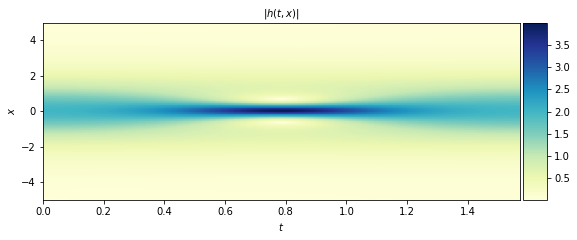

In [26]:
# 使用Tester_Schrodinger进行预测，复现复现文章中的Figure2（只画出预测结果）
args = Options_Schrodinger().parse()
args.problem = Problem_Schrodinger()

args.model = ResPINN_Schrodinger(2, 2, dim_hidden=args.dim_hidden, res_blocks=args.res_blocks)
args.testset = Testset_Schrodinger(args.problem, method='ground_truth')  
tester = Tester_Schrodinger(args)
tester.plot()